In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd 'drive/MyDrive/Colab Notebooks/BMI-Decoding'

/content/drive/MyDrive/Colab Notebooks/BMI-Decoding


In [3]:
# import packages
import h5py
import numpy as np
from functions.preprocess import input_shaping, split_index
from functions.decoders import lstm_decoder
from functions.metrics import compute_rmse, compute_pearson
import matplotlib.pyplot as plt
import seaborn as sns
import time as timer
from tensorflow import random
from scipy import stats

In [4]:
seed = 2020 # random seed for reproducibility

print ("Starting simulation")
run_start = timer.time()

feature_list = ['sua_rate','mua_rate']
feature = feature_list[1] # select which spike feature: SUA=0, MUA=1

# specify filename to be processed (choose from the list available at https://zenodo.org/record/583331)
file_name = 'indy_20160915_01'          # file name
kinematic_folder = 'kinematic_data/'    # kinematic data folder
feature_folder = 'spike_data/features/' # spike features folder
result_folder = 'results/'              # results folder

Starting simulation


In [5]:
wdw_time = 0.256 # window size in second
lag = -32 # lag between kinematic and feature data (minus indicate feature lagging behaind kinematic)
delta_time = 0.004 # sampling interval in second
wdw_samp = int(round(wdw_time/delta_time))
ol_samp = wdw_samp-1

## Importing data to be processed

In [6]:
# open spike features from hdf5 file
feature_file = feature_folder+file_name+'_spike_features_'+str(int(wdw_time*1e3))+'ms.h5'
print ("Loading input features from file: "+feature_file)
with h5py.File(feature_file,'r') as f:
    input_feature = f[feature][()]

Loading input features from file: spike_data/features/indy_20160915_01_spike_features_256ms.h5


In [7]:
# open kinematic data from hdf5 file
kinematic_file = kinematic_folder+file_name+'_kinematic_data.h5'
print ("Loading kinematic data from file: "+kinematic_file)
#fields: ['cursor_acc', 'cursor_pos', 'cursor_time', 'cursor_vel', 'target_pos']
with h5py.File(kinematic_file,'r') as f:
    cursor_vel = f['cursor_vel'][()] # in mm/s

Loading kinematic data from file: kinematic_data/indy_20160915_01_kinematic_data.h5


## Preprocessing the data to fit a model

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(input_feature)
y_mm = mm.fit_transform(cursor_vel)

In [9]:
print(X_ss.shape, y_mm.shape)

(95262, 88) (95262, 2)


In [10]:
#first 90,000 for training

X_train = X_ss[:90000, :]
X_test = X_ss[90000:, :]

y_train = y_mm[:90000, :]
y_test = y_mm[90000:, :] 

In [11]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (90000, 88) (90000, 2)
Testing Shape (5262, 88) (5262, 2)


## Adjusting the data for pytorch model

In [12]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

In [13]:
#converting nparrays to tensors for pytorch

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))


In [14]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([90000, 1, 88]) torch.Size([90000, 2])
Testing Shape torch.Size([5262, 1, 88]) torch.Size([5262, 2])


## Importing spytorch functions

In [15]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 88*1
nb_hidden  = 100
nb_outputs = 2

time_step = 1e-3
nb_steps  = 40

batch_size = 256

dtype = torch.float
# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [16]:
tau_mem = 10e-3
tau_syn = 5e-3

# beta    = float(np.exp(-time_step/tau_mem))
# weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with



print("init done")

init done


In [17]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T
 

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, sample_size=nb_steps,overlap_units=1,shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(0,len(X)-sample_size,overlap_units)

#     # compute discrete firing times
#     tau_eff = 20e-3/time_step
#     firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int)
#     unit_numbers = np.arange(nb_units)
    
    if shuffle:
        np.random.shuffle(sample_index)
    
    

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        
#         for batch_sample_i in range(batch_size):
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        # batch_index = np.arange(sample_index[counter],sample_index[counter]+batch_size)


        
        X_batch = np.zeros((batch_size,sample_size,X.shape[-1]))
        y_batch = np.zeros((batch_size,y.shape[-1]))
        for bc,idx in enumerate(batch_index):
            X_batch[bc,:,:] = X[idx:idx+sample_size,:,:].reshape((1,sample_size,X.shape[-1]))
            y_batch[bc, :] = y[idx+sample_size-1,:]
            
#         i = torch.LongTensor(coo).to(device)
#         v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.FloatTensor(X_batch).to(device)
        y_batch = torch.tensor(y_batch,device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [23]:

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [110]:
class Spiking_Linear_layer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()

        self.alpha = nn.Parameter(torch.empty((1,size_out), device=device, dtype=dtype), requires_grad=True)
        self.beta = nn.Parameter(torch.empty((1,size_out), device=device, dtype=dtype), requires_grad=True)

        torch.nn.init.normal_(self.alpha, mean=np.exp(-time_step/tau_syn), std=1e-6) #using time constant such that you get alpha and beta to 0.9, change to uniform
        torch.nn.init.normal_(self.beta, mean=np.exp(-time_step/tau_mem), std=1e-6)

        weight_scale = 7*(1.0-np.exp(-time_step/tau_mem)) # this should give us some spikes to begin with

        self.size_in = size_in
        self.size_out = size_out

        self.w1 = nn.Parameter(torch.empty((size_in, size_out),  device=device, dtype=dtype, requires_grad=True))
        torch.nn.init.uniform_(self.w1, -2*weight_scale/np.sqrt(size_in), 2*weight_scale/np.sqrt(size_in))

        self.v1 = nn.Parameter(torch.empty((size_out, size_out), device=device, dtype=dtype, requires_grad=True))
        torch.nn.init.uniform_(self.v1, -2*weight_scale/np.sqrt(size_in), 2*weight_scale/np.sqrt(size_in))

        self.mem_rec = []
        self.spk_rec = []

    def forward(self, inputs):
        # h1 = torch.einsum("abc,cd->abd", (inputs, self.w1))
        syn = torch.zeros((batch_size,self.size_out), device=device, dtype=dtype)
        mem = torch.zeros((batch_size,self.size_out), device=device, dtype=dtype)

        if hasattr(self, 'alpha'):
          self.alpha.data = torch.clamp(self.alpha.data, 0.9, 0.995)
        if hasattr(self, 'beta'):
          self.beta.data = torch.clamp(self.beta.data, 0.9, 0.995)

        self.mem_rec = []
        self.spk_rec = []
        

        # Compute hidden layer activity
        out = torch.zeros((batch_size, self.size_out), device=device, dtype=dtype)
        h1_from_input = torch.einsum("abc,cd->abd", (inputs, self.w1))        
        for t in range(nb_steps):
            # if t%5==0:
            #     print(t/nb_steps, ' ', end='')
            h1 = h1_from_input[:,t,:] 
            h1 += torch.einsum("ab,bc->ac", (out, self.v1))
            mthr = mem-1.0
            out = spike_fn(mthr)
            rst = out.detach() # We do not want to backprop through the reset

            new_syn = self.alpha*syn +h1
    #         new_mem = (self.beta*mem +syn)*(1.0-rst)
            new_mem = self.beta*(mem - rst) + rst + (1 - self.beta.detach())*syn

            self.mem_rec.append(mem)
            self.spk_rec.append(out)
            
            mem = new_mem
            syn = new_syn
        # print('')

        self.mem_rec = torch.stack(self.mem_rec,dim=1)
        self.spk_rec = torch.stack(self.spk_rec,dim=1)

        return self.mem_rec, self.spk_rec

In [111]:
class Spiking_Readout(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()


        self.alpha = nn.Parameter(torch.empty((1,size_out), device=device, dtype=dtype), requires_grad=True)
        self.beta = nn.Parameter(torch.empty((1,size_out), device=device, dtype=dtype), requires_grad=True)

        torch.nn.init.normal_(self.alpha, mean=np.exp(-time_step/tau_syn), std=1e-6)
        torch.nn.init.normal_(self.beta, mean=np.exp(-time_step/tau_mem), std=1e-6)

        self.size_in = size_in
        self.size_out = size_out

        weight_scale = 7*(1.0-np.exp(-time_step/tau_mem)) # this should give us some spikes to begin with

        self.w2 = nn.Parameter(torch.empty((size_in, size_out), device=device, dtype=dtype, requires_grad=True))
        torch.nn.init.uniform_(self.w2, -2*weight_scale/np.sqrt(size_out), 2*weight_scale/np.sqrt(size_out))

        self.w3 = nn.Parameter(torch.empty((size_out*nb_steps, size_out), device=device, dtype=dtype, requires_grad=True))
        torch.nn.init.uniform_(self.w2, -2*weight_scale/np.sqrt(size_out), 2*weight_scale/np.sqrt(size_out))

    def forward(self, inputs):

        if hasattr(self, 'alpha'):
          self.alpha.data = torch.clamp(self.alpha.data, 2/np.e, 0.995)
        if hasattr(self, 'beta'):
          self.beta.data = torch.clamp(self.beta.data, 2/np.e, 0.995)

        h2= torch.einsum("abc,cd->abd", (inputs, self.w2))
        flt = torch.zeros((batch_size,self.size_out), device=device, dtype=dtype)
        out = torch.zeros((batch_size,self.size_out), device=device, dtype=dtype)
        out_rec = []
        for t in range(nb_steps):
            new_flt = self.alpha*flt +h2[:,t]
            new_out = self.beta*out +flt

            flt = new_flt
            out = new_out

            out_rec.append(out)

        out_rec = torch.stack(out_rec,dim=1)
        out_rec = out_rec.reshape(batch_size,-1)

        final_out= torch.einsum("ab,bc->ac", (out_rec, self.w3))

        return final_out

In [112]:
class Spiking_Network(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Spiking_Network, self).__init__() 
        self.spk_layers = [Spiking_Linear_layer(D_in, 5*H),
          Spiking_Linear_layer(5*H, 3*H),
          Spiking_Linear_layer(3*H, 3*H),
          Spiking_Linear_layer(3*H, 2*H)]

        self.rd_out = Spiking_Readout(2*H, D_out)
        # self.linear1 = nn.Linear(D_out*nb_steps, D_out).to(device)
        self.prs = {
            'f_lower':0.001,
            'f_upper':100,
            'p_up':2,
            'lambda_lower':5e-3,
            'lambda_upper':0.01,
            'batch_size':batch_size
        }


    def forward(self, inputs):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        mem_rec, spk_rec = (0,inputs)

        loss = 0

        for layer in self.spk_layers:
          mem_rec,spk_rec = layer(spk_rec)


          l_low = self.loss_lower(layer, self.prs)
          l_up = self.loss_upper(layer, self.prs)
          l_reg = (l_up + l_low).sum()
          loss += (1./self.prs['batch_size'])*l_reg


        out_rec = self.rd_out(spk_rec)
        # out_rec = self.linear1(out_rec)

        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs, loss
  
    def loss_upper(self, spk_layer, prs):
      tmp = (1./spk_layer.size_out)*spk_layer.spk_rec.sum(1).sum(1) - prs['f_upper']
      loss_upper = prs['lambda_upper']*((torch.clamp(tmp, min=0.))** prs['p_up'])
      return loss_upper
    def loss_lower(self, spk_layer, prs):
      tmp = prs['f_lower'] - spk_layer.spk_rec.sum(1)
      tmp = (torch.clamp(tmp, min=0.))**2
      loss_lower = prs['lambda_lower']*tmp.sum(1)
      return loss_lower / spk_layer.size_out
    
    
    

In [113]:
class Spiking_Network(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Spiking_Network, self).__init__() 
        self.spk1 = Spiking_Linear_layer(D_in, 5*H)
        self.spk2 = Spiking_Linear_layer(5*H, 3*H)
        self.spk3 = Spiking_Linear_layer(3*H, 3*H)
        self.spk4 = Spiking_Linear_layer(3*H, 2*H)

        self.rd_out = Spiking_Readout(2*H, D_out)
        # self.linear1 = nn.Linear(D_out*nb_steps, D_out).to(device)

    def forward(self, inputs):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """

        mem_rec,spk_rec = self.spk1(inputs)
        mem_rec,spk_rec = self.spk2(spk_rec)
        mem_rec,spk_rec = self.spk3(spk_rec)
        mem_rec,spk_rec = self.spk4(spk_rec)

        out_rec = self.rd_out(spk_rec)
        # out_rec = self.linear1(out_rec)

        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs
    

In [117]:
def train(x_data, y_data, x_val, y_val, lr=2e-3, nb_epochs=10):

    model = Spiking_Network(nb_inputs, nb_hidden, nb_outputs)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))

    decayRate = 0.975
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

    linear_fn = nn.LogSoftmax(dim=1)
    # linear_fn = nn.Linear(2,2)
    loss_fn = nn.MSELoss()
    
    loss_hist = []
    loss_hist_val = []

    early_stop = 50

    early_stop_ctr = 0
    for e in range(nb_epochs):
        
        local_loss = []
        local_val_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output,_ = model(x_local)
            # velocity_out,_=torch.max(output,1)
            # velocity_out = linear_fn(m)



            loss_train = loss_fn(output.float(), y_local.float()) 
            


            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            local_loss.append(loss_train.item())

        for x_local, y_local in sparse_data_generator(x_val, y_val, batch_size, nb_steps, nb_inputs):
            val_out,_ = model(x_local)
            loss_test = loss_fn(val_out.float(), y_local.float())
            
            local_val_loss.append(loss_test.item())
        
        
        mean_loss = np.mean(local_loss)
        mean_val_loss = np.mean(local_val_loss)

        my_lr_scheduler.step()

        print("Epoch %i: loss=%.5f  validation loss=%.5f"%(e+1,mean_loss,mean_val_loss))

        if e>early_stop:
          if not mean_val_loss < min(loss_hist_val[e-early_stop:]):
            early_stop_ctr += 1
        if early_stop_ctr >= early_stop:
          break
        

        loss_hist.append(mean_loss)
        loss_hist_val.append(mean_val_loss)

        

        
        
    return model, loss_hist, loss_hist_val

In [118]:
import gc
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing


In [ ]:
model, loss_hist, val_loss = train(X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors, lr=5e-7, nb_epochs=100)

Epoch 1: loss=0.21206  validation loss=0.19613
Epoch 2: loss=0.16006  validation loss=0.13749
Epoch 3: loss=0.10724  validation loss=0.08925
Epoch 4: loss=0.07175  validation loss=0.05984
Epoch 5: loss=0.05036  validation loss=0.04253
Epoch 6: loss=0.03876  validation loss=0.03436
Epoch 7: loss=0.03307  validation loss=0.03047
Epoch 8: loss=0.02986  validation loss=0.02772
Epoch 9: loss=0.02746  validation loss=0.02580
Epoch 10: loss=0.02542  validation loss=0.02407
Epoch 11: loss=0.02361  validation loss=0.02235
Epoch 12: loss=0.02195  validation loss=0.02099
Epoch 13: loss=0.02043  validation loss=0.01977
Epoch 14: loss=0.01908  validation loss=0.01845
Epoch 15: loss=0.01787  validation loss=0.01748
Epoch 16: loss=0.01677  validation loss=0.01647
Epoch 17: loss=0.01579  validation loss=0.01565
Epoch 18: loss=0.01491  validation loss=0.01492
Epoch 19: loss=0.01414  validation loss=0.01424
Epoch 20: loss=0.01344  validation loss=0.01356
Epoch 21: loss=0.01285  validation loss=0.01312
E

In [40]:
plt.figure(figsize=(8,5),dpi=130)
plt.plot(loss_hist)
plt.plot(val_loss)
plt.legend(['training loss', 'val loss'])
plt.ylim
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

NameError: ignored

<Figure size 1040x650 with 0 Axes>

In [181]:
from matplotlib.gridspec import GridSpec

def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [185]:
correlation_array_1 = []
correlation_array_2 = []

pred = []
y_val = []
for x_local, y_local in sparse_data_generator(X_test_tensors_final, y_test_tensors, batch_size, nb_steps, nb_inputs, shuffle=False):
    val_out,mem = model(x_local)
    val_out = val_out.detach().cpu()
    pred.append(val_out)
    y_val.append(y_local)
    

    correlation_array_1.append(stats.pearsonr(val_out[:,0].cpu(), y_local[:,0].cpu())[0])
    correlation_array_2.append(stats.pearsonr(val_out[:,1].cpu(), y_local[:,1].cpu())[0])

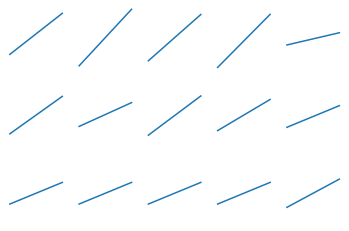

In [190]:
plot_voltage_traces(pred[15])

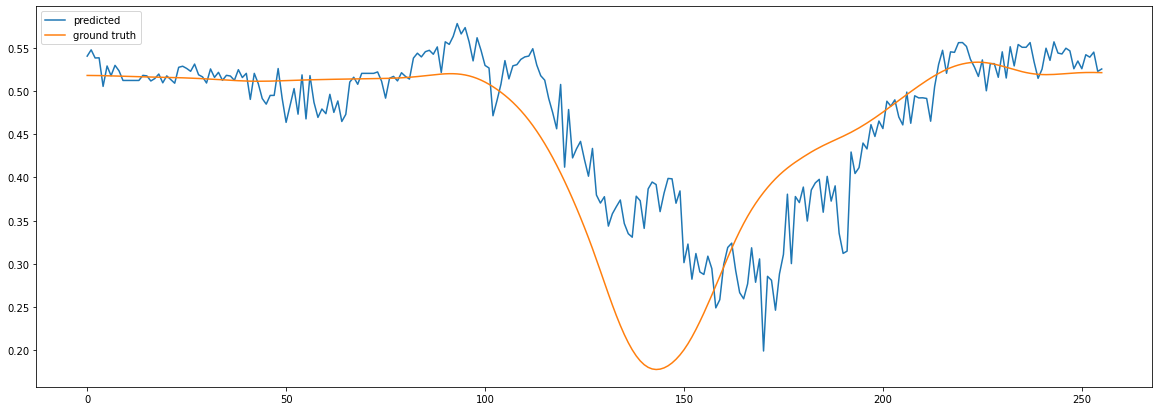

In [189]:
sample=15
fig = plt.figure()
plt.plot(pred[sample][:,1])
plt.plot(y_val[sample][:,1].cpu())
plt.legend(['predicted', 'ground truth'])
fig.set_size_inches(20,7)

In [143]:
correlation_array_1 = [x for x in correlation_array_1 if str(x) != 'nan']
correlation_array_2 = [x for x in correlation_array_2 if str(x) != 'nan']

In [187]:
print(np.mean(correlation_array_1), np.std(correlation_array_1))
print(np.mean(correlation_array_2), np.std(correlation_array_2))

0.3606988655175808 0.3143640037500568
0.44638229338762214 0.3761820220751572


In [188]:
print(np.mean(correlation_array_1 + correlation_array_2), np.std(correlation_array_1 + correlation_array_2))

0.4035405794526016 0.34929104303725


In [98]:
val_out[:,0].shape

torch.Size([256])

In [99]:
pred[0][1]

tensor([0.4792, 0.5190])

In [100]:
np.corrcoef(pred[0][1],y_val[0])

TypeError: ignored